In [1]:
pip install sentence-transformers torch faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import math
from tqdm import tqdm
import faiss
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
import os
print(os.getcwd())

C:\Users\16142\Desktop\OSU\Senior Year files\ERDOS\Somm_Wine_Reccomendation\Modeling


In [4]:
wine = pd.read_csv('../Data/Raw Data/winemag-data-130k-v2.csv', encoding='utf-8', on_bad_lines='skip')
wine.rename(columns={'Unnamed: 0': 'id'}, inplace=True)


In [5]:
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# Generating and Exporting Description Embeddings to a Tensor File

In [ ]:
# This code was used to create the description embeddings tensor file.
# You don't have to run it again.
# It takes about an hour to run.

# Initialize the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Extract the "description" column as a list
descriptions = wine['description'].tolist()

# Set batch size
batch_size = 100

# Calculate the number of batches needed
num_batches = math.ceil(len(descriptions) / batch_size)

# Initialize a list to store embeddings
description_embeddings = []

# Process data in batches with tqdm
for i in tqdm(range(num_batches), desc="Processing Batches"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(descriptions))
    batch_descriptions = descriptions[start_idx:end_idx]

    # Encode the batch of descriptions using the model
    batch_embeddings = model.encode(batch_descriptions)

    # Append the batch embeddings to the list
    description_embeddings.extend(batch_embeddings)

# Convert the list of embeddings to a PyTorch tensor
description_tensor = torch.tensor(description_embeddings)

# Now each observation description has been encoded as a sparse vector (tensor)

# Save the tensor to a file
torch.save(description_tensor, 'description_embeddings.pt')

Processing Batches: 100%|██████████| 1300/1300 [57:37<00:00,  2.66s/it]
<ipython-input-20-269cb6eaabd0>:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  description_tensor = torch.tensor(description_embeddings)


# KNN Search with Faiss

In [13]:
knn_vectors = torch.load("../Data/description_embeddings.pt")
# labels are the just wine id's
knn_labels = wine.id.astype(str).tolist()

In [14]:
# Convert the data to NumPy arrays for use with faiss
vectors_np = knn_vectors.numpy()

# Determine the dimension of the vectors
dimension = vectors_np.shape[1]  # This represents the dimension of the vectors

# Build the Faiss index
index = faiss.IndexFlatL2(dimension)  # Create a Faiss index with L2 (Euclidean) distance metric
index.add(vectors_np)  # Add the data vectors to the index


In [37]:
# Initialize a sentence transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode the text query to obtain a vector
query_text = 'I want a wine with melon flavour that is not bitter'
query_vector = model.encode([query_text])[0]

# Query the index with the vector
k = 20  # Number of neighbors to return

# Perform a nearest neighbor search to find the closest neighbors to the query vector(s).
# D will contain squared L2 distances between the query vector and its neighbors.
# I will contain the indices of the nearest neighbors in the dataset.
D, I = index.search(np.array([query_vector]), k)

# Get labels (wine id's) of the neighbors
neighbor_labels = [knn_labels[i] for i in I[0]]

# Extract rows from the wine DataFrame
result = wine.iloc[I[0]]

# PCA on the nearest 20 reviews

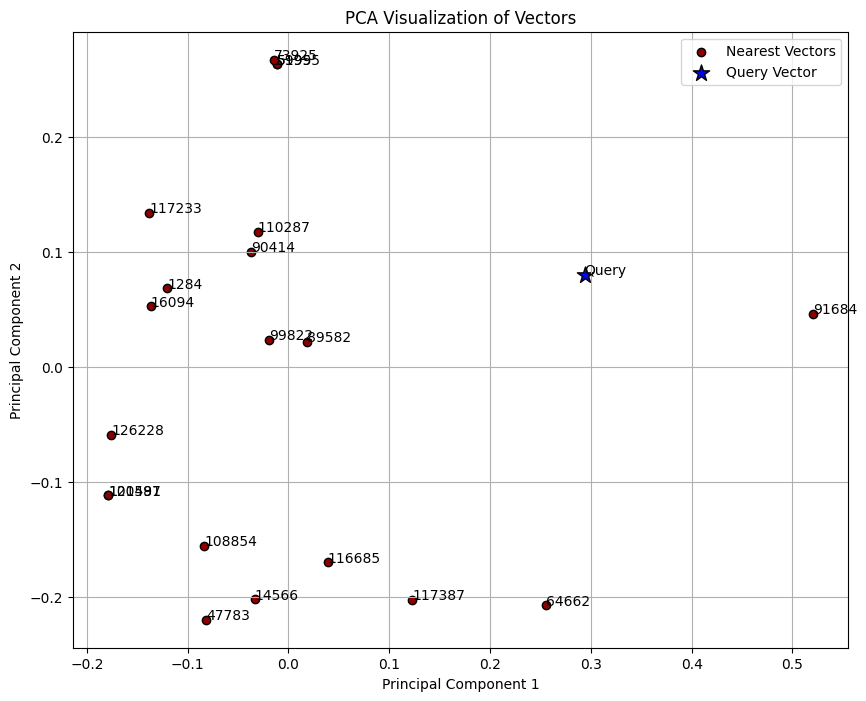

In [60]:
# Include the query vector
all_vectors = np.vstack([query_vector, knn_vectors[I[0]]])

# Apply PCA
pca = PCA(n_components=2)
transformed_vectors = pca.fit_transform(all_vectors)

# Visualize with a scatter plot
plt.style.use('default')
plt.figure(figsize=(10, 8))
# Plot the neighbors
plt.scatter(transformed_vectors[1:, 0], transformed_vectors[1:, 1], c='darkred', edgecolors='k', label="Nearest Vectors")
# Plot the query vector (it's the first one now)
plt.scatter(transformed_vectors[0, 0], transformed_vectors[0, 1], c='blue', edgecolors='k', s=150, marker='*', label="Query Vector")

for i, label in enumerate(['Query'] + neighbor_labels):  # Annotate the points with their labels
    plt.annotate(label, (transformed_vectors[i, 0], transformed_vectors[i, 1]))

plt.title("PCA Visualization of Vectors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Most frequent words from the nearest 20 reviews nearest to the query text

['Sweet melon and apple aromas fall off to cheesy. The palate has some jump in it, but the flavors are generic and sweet, suggesting mealy citrus and banana. A rudimentary wine with a gimmicky name.'
 'Lightly peppery, herbal aromas and honeydew-melon flavors give personality to this soft, soothing and almost sweet wine.'
 'A wood-aged wine, with the wood flavors well balanced with crisp acidity. Lemon, peach and melon flavors mellifluously combine to give a rounded wine with a tang. It shows a strong mineral-textured aftertaste, a product of the granite soil of the vineyard. Drink this richly flavored wine now.'
 'A wood-aged wine, with the wood flavors well balanced with crisp acidity. Lemon, peach and melon flavors mellifluously combine to give a rounded wine with a tang. It shows a strong mineral-textured aftertaste, a product of the granite soil of the vineyard. Drink this richly flavored wine now.'
 'Though simple, this is a fresh, crisp, lightly herbal wine, with fruit flavors e

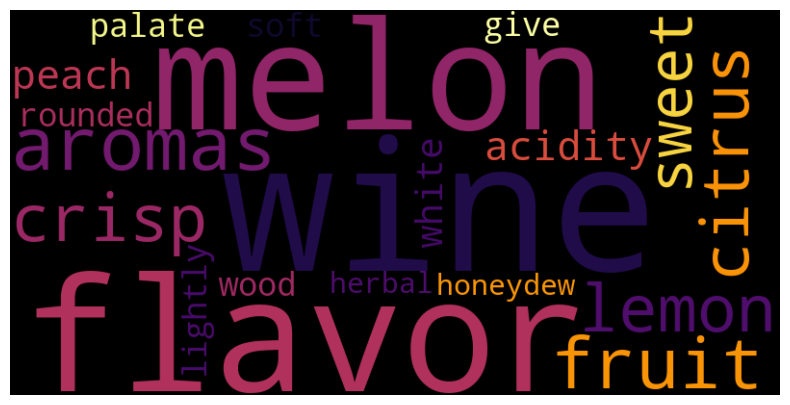

In [40]:
# print(result['description'].values)

nearestDescrptions = result['description'].tolist()

# Combine the texts into a single string
combined_text = ' '.join(nearestDescrptions)

# Create a word cloud visualization
wordcloud = WordCloud(background_color="black",
                      max_words=20,
                      contour_width=3,
                      colormap='inferno',
                      width=800, height=400)

# Generate the word cloud from the combined text
wordcloud.generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()